# 学習済みモデルを利用した推論

In [12]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms

In [13]:
# バージョンチェック
print("PyTorch Version: ", torch.__version__)
print("TorchVision Version: ", torchvision.__version__)

PyTorch Version:  1.3.1
TorchVision Version:  0.4.2


### VGG16モデルのロード

In [14]:
# VGG-16モデルのインスタンスを生成
use_pretained = True
net = models.vgg16(pretrained=use_pretained)
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [15]:
# モデルのネットワーク構成を出力
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### 入力画像の前処理

In [16]:
# 224 x 224 リサイズ
# 平均(0.485, 0.456, 0.406), 標準偏差(0.229, 0.224, 0.225)　規格化

# 入力画像の前処理クラス
class BaseTransform():

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([
            transforms.Resize(resize),      # 画像の短辺が244になるようにリサイズ
            transforms.CenterCrop(resize),  # 画像中央を切り抜く(resize x resize)
            transforms.ToTensor(),          # Torchテンソルに変換
            transforms.Normalize(mean, std) # 色情報の規格化
        ])

    def __call__(self, img):
        return self.base_transform(img)

###  画像前処理動作を確認

In [17]:
def preprocessImage():

    # 画像読み込み
    image_file_path = "./data/Pytorch/goldenretriever-3724972_640.jpg"
    img = Image.open(image_file_path)

    # 原画像を表示
    plt.imshow(img)
    plt.show()

    # 前処理と処理後の画像を表示
    resize = 224
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    transform = BaseTransform(resize, mean, std)
    img_transformed = transform(img) # torch.Size([3, 224, 224])
    img_transformed_transposed = img_transformed.numpy().transpose((1,2,0))

    print("img_transformed_transposed :",  img_transformed_transposed)
    img_transformed_transposed_cliped = np.clip(img_transformed_transposed, 0, 1) # 0-1にクリップ
    print("img_transformed_transposed_cliped :",  img_transformed_transposed_cliped)
    plt.imshow(img_transformed_transposed_cliped)
    plt.show()

    return img_transformed # torch.Size([3, 224, 224])

### VGG-16による推論

In [18]:
ILSVRC_class_index = json.load(open('./data/Pytorch/imagenet_class_index.json', 'r'))
print("ILSVRC_class_index :", ILSVRC_class_index)

# 推論クラス
class ILSVRCPredictor():

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        maxID = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxID)][1]
        return predicted_label_name

ILSVRC_class_index : {'0': ['n01440764', 'tench'], '1': ['n01443537', 'goldfish'], '2': ['n01484850', 'great_white_shark'], '3': ['n01491361', 'tiger_shark'], '4': ['n01494475', 'hammerhead'], '5': ['n01496331', 'electric_ray'], '6': ['n01498041', 'stingray'], '7': ['n01514668', 'cock'], '8': ['n01514859', 'hen'], '9': ['n01518878', 'ostrich'], '10': ['n01530575', 'brambling'], '11': ['n01531178', 'goldfinch'], '12': ['n01532829', 'house_finch'], '13': ['n01534433', 'junco'], '14': ['n01537544', 'indigo_bunting'], '15': ['n01558993', 'robin'], '16': ['n01560419', 'bulbul'], '17': ['n01580077', 'jay'], '18': ['n01582220', 'magpie'], '19': ['n01592084', 'chickadee'], '20': ['n01601694', 'water_ouzel'], '21': ['n01608432', 'kite'], '22': ['n01614925', 'bald_eagle'], '23': ['n01616318', 'vulture'], '24': ['n01622779', 'great_grey_owl'], '25': ['n01629819', 'European_fire_salamander'], '26': ['n01630670', 'common_newt'], '27': ['n01631663', 'eft'], '28': ['n01632458', 'spotted_salamander'],

In [19]:
# 前処理
def inferenceImage(img_transformed):

    # ILSVRCPredictorのインスタンス
    predictor = ILSVRCPredictor(ILSVRC_class_index)

    # バッチサイズの次元を追加する
    inputs = img_transformed.unsqueeze_(0) # torch.Size([1, 3, 224, 224])

    # 推論
    out = net(inputs) # torch.Size([1, 1000])
    result = predictor.predict_max(out)

    return result

### 実行

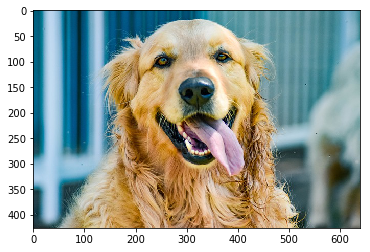

img_transformed_transposed : [[[-1.5014129   0.18767506  0.98422676]
  [-0.88492167  0.48529422  1.2456646 ]
  [-0.4739276   0.76540625  1.454815  ]
  ...
  [-0.6451751   0.48529422  0.8622224 ]
  [-0.6109256   0.50280124  0.8796516 ]
  [-0.43967807  0.5903362   1.0016559 ]]

 [[-1.5014129   0.2051822   1.0016559 ]
  [-0.8677969   0.5203082   1.2805231 ]
  [-0.4739276   0.74789923  1.454815  ]
  ...
  [-0.67942464  0.45028022  0.827364  ]
  [-0.59380084  0.50280124  0.8796516 ]
  [-0.45680285  0.5903362   1.0016559 ]]

 [[-1.4671633   0.2577032   1.0365143 ]
  [-0.8335474   0.5378152   1.3153814 ]
  [-0.45680285  0.76540625  1.454815  ]
  ...
  [-0.67942464  0.45028022  0.827364  ]
  [-0.59380084  0.5203082   0.8970808 ]
  [-0.45680285  0.57282925  0.98422676]]

 ...

 [[ 1.1529241   0.83543426 -0.21838771]
  [ 1.0673003   0.69537824 -0.34039208]
  [ 0.9816765   0.6078432  -0.37525046]
  ...
  [-1.0561693  -0.687675   -0.514684  ]
  [-1.8267832  -1.2829131  -1.1421349 ]
  [-1.5870366  

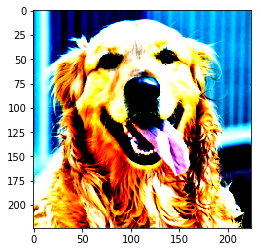

入力画像の予測結果 : golden_retriever


In [20]:
# 1) 画像前処理
img_transformed = preprocessImage()

# 2) 推論
result = inferenceImage(img_transformed)

# 予測結果を出力する
print("入力画像の予測結果 :", result)